In [233]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Word Cloud imports
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import spacy

# Topic Modeling imports 
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

# N-grams imports
from nltk import word_tokenize
from nltk.util import ngrams

In [156]:
nltk.download('punkt') # need to download punkt package from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [157]:
stop_words_set = set(stopwords.words("english"))

In [222]:
nlp = spacy.load('en_core_web_lg')

In [171]:
def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()

    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()

    # Plot the pairwise joint distributions
    # print("\nTo check pairwise joint distribution of numeric data")
    # if hue==None:
    #     sns.pairplot(df.select_dtypes(include=np.number))
    # else:
    #     sns.pairplot(df.select_dtypes(include=np.number).join(df[[hue]]), hue=hue)
    # plt.show()
    print("\nTo check correlation of numeric data")
    # plot the heatmap
    sns.heatmap(df.corr(numeric_only=True),
                xticklabels=df.corr(numeric_only=True).columns,
                yticklabels=df.corr(numeric_only=True).columns,
                cmap="Blues", annot=True)


def top5(df):
    """Given dataframe, generate top 5 unique values for non-numeric data"""
    columns = df.select_dtypes(include=['object', 'category']).columns
    for col in columns:
        print("Top 5 unique values of " + col)
        print(df[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
              :min(5, len(df[col].value_counts()))])
        print(" ")


def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data"""
    print("\nTo check: \nUnique count of non-numeric data\n")
    print(df.select_dtypes(include=['object', 'category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()
       
    
def eda(df):
    """Given dataframe, generate exploratory data analysis"""
    # check that input is pandas dataframe
    if type(df) != pd.core.frame.DataFrame:
        raise TypeError("Only pandas dataframe is allowed as input")

    # replace field that's entirely space (or empty) with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True)

    print("Preview of data:")
    display(df.head(3))

    print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
    print(df.info())

    # generate preview of entries with null values
    if df.isnull().any(axis=None):
        print("\nPreview of data with null values:")
        display(df[df.isnull().any(axis=1)].head(3))
        missingno.matrix(df)
        plt.show()

    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
        display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("\nNo duplicated entries found")

    # EDA of categorical data
    categorical_eda(df)

    # EDA of numeric data
    numeric_eda(df)
    
    
def Displaywordcloud(text, additional_stopwords=None):
    # Create a set of stopwords
    stopwords = set(STOPWORDS)
    
    if additional_stopwords:
        # Replace multi-word phrases with single words in the text
        for phrase in additional_stopwords:
            if ' ' in phrase:
                combined_word = phrase.replace(' ', '')
                text = text.replace(phrase, combined_word)
                stopwords.add(combined_word)

        # Add any additional stopwords, if provided
        stopwords.update(additional_stopwords)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black',
                    stopwords = stopwords,
                    min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def get_entities(text):
    entities_dict = {}
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        if label not in entities_dict:
            entities_dict[label]=set()
        entities_dict[label].add(entity.text)
    return entities_dict

def draw_entities_word_cloud(entity_type,min_times=10):
    stopwords = set(STOPWORDS)
    stopwords_parts = {}
    wordcloud = WordCloud(width=800,height=800,
                          stopwords=stopwords,
                          background_color="black",
                         min_font_size=10)
    def skip_entity(e):
        if e in stopwords:
            return True
        for p in stopwords_parts:
            if p in e:
                return True
        return False
    d={k:v for k,v in count_entities_dict[entity_type].items() if v>min_times and not skip_entity(k)}
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud)

In [180]:
df = pd.read_csv('sentiment_df.csv')
df# Named-Entity Recognition

date             user  \
0       2020-06-07 21:50:52+00:00  brittany_broski   
1       2020-11-04 23:49:38+00:00              AOC   
2       2020-07-28 13:21:06+00:00   MargBarAmerica   
3       2020-12-04 18:27:14+00:00          nytimes   
4       2020-07-28 12:57:33+00:00   YesYoureRacist   
...                           ...              ...   
152451  2015-12-29 13:21:28+00:00         lanceb62   
152452  2015-10-17 15:05:00+00:00        JamieGump   
152453  2015-10-23 12:37:56+00:00     KerryWMartin   
152454  2015-08-01 01:10:26+00:00  PunkRockLiberty   
152455  2015-01-03 06:28:09+00:00     matkabolava_   

                                                    tweet   likes  replies  \
0       Next up on the docket: free every black man un...  542202      938   
1       Shout out to the hard work of grassroots organ...  289942     1573   
2       i still can't get over the democrats overwhelm...   24154      156   
3       The House has voted to decriminalize marijuana...   18705      715   
4       Good morning! 57% of Americans and 78% of Demo...   15003      117   
...                                                   ...     ...      ...   
152451  Soros Foundation promoted drug legalization wo...       1        0   
152452  Waiting to hear @TexasGOP say anything about #...       1        0   
152453  "Police work for #narcos because they pay bett...       0        1   
152454  Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...       0        0   
152455  that is why I'm so against the legalization of...       0        1   

        retweets                                       hashtags  \
0         148464                                             []   
1          18519                                             []   
2           1975                                             []   
3           5606                                             []   
4           4613                                             []   
...          ...                                            ...   
152451         1                                             []   
152452         0  ['druglegalization', 'ttf', 'bordersecurity']   
152453         0                 ['narcos', 'druglegalization']   
152454         1                                             []   
152455         0                                             []   

                    user_id              topic  year  \
0       1262905431602589696       legalization  2020   
1                 138203134       legalization  2020   
2                  17109158       legalization  2020   
3                    807095       legalization  2020   
4                 858924511       legalization  2020   
...                     ...                ...   ...   
152451           2874372175  drug legalization  2015   
152452            528261651  drug legalization  2015   
152453           2545495004  drug legalization  2015   
152454           1278031291  drug legalization  2015   
152455           2376222163  drug legalization  2015   

                                              clean_tweet sentiment  
0       next docket free every black man unfairly rott...  Positive  
1       shout hard work grassroots organizers successf...  Positive  
2       still can t get democrats overwhelmingly votin...  Negative  
3       house voted decriminalize marijuana expunge no...   Neutral  
4       good morning 57 americans 78 democrats support...   Neutral  
...                                                   ...       ...  
152451  soros foundation promoted drug legalization wo...   Neutral  
152452  waiting hear texasgop say anything druglegaliz...   Neutral  
152453  police work narcos pay better interview drugle...   Neutral  
152454  govt funded anti drug program d a r e called l...   Neutral  
152455  i m legalization drug simple mj deal ended 3 p...  Negative  

[152456 rows x 12 columns]

In [217]:
topics = df.topic.unique().tolist()

# EDA

Preview of data:


date             user  \
0  2020-06-07 21:50:52+00:00  brittany_broski   
1  2020-11-04 23:49:38+00:00              AOC   
2  2020-07-28 13:21:06+00:00   MargBarAmerica   

                                               tweet   likes  replies  \
0  Next up on the docket: free every black man un...  542202      938   
1  Shout out to the hard work of grassroots organ...  289942     1573   
2  i still can't get over the democrats overwhelm...   24154      156   

   retweets hashtags              user_id         topic  year  \
0    148464       []  1262905431602589696  legalization  2020   
1     18519       []            138203134  legalization  2020   
2      1975       []             17109158  legalization  2020   

                                         clean_tweet sentiment  
0  next docket free every black man unfairly rott...  Positive  
1  shout hard work grassroots organizers successf...  Positive  
2  still can t get democrats overwhelmingly votin...  Negative


To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152456 entries, 0 to 152455
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         152456 non-null  object
 1   user         152456 non-null  object
 2   tweet        152456 non-null  object
 3   likes        152456 non-null  int64 
 4   replies      152456 non-null  int64 
 5   retweets     152456 non-null  int64 
 6   hashtags     152456 non-null  object
 7   user_id      152456 non-null  int64 
 8   topic        152456 non-null  object
 9   year         152456 non-null  int64 
 10  clean_tweet  152456 non-null  object
 11  sentiment    152456 non-null  object
dtypes: int64(5), object(7)
memory usage: 14.0+ MB
None

No duplicated entries found

To check: 
Unique count of non-numeric data

date           152024
user            51756
tweet          150100
hashtags        30170

count          mean           std     min         25%  \
likes     152456.0  5.898749e+02  5.932035e+03     0.0         9.0   
replies   152456.0  2.537571e+01  1.926451e+02     0.0         1.0   
retweets  152456.0  1.610820e+02  1.695266e+03     0.0         3.0   
user_id   152456.0  2.411735e+17  4.579569e+17    20.0  34371835.0   
year      152456.0  2.018939e+03  2.178273e+00  2015.0      2017.0   

                  50%           75%           max  
likes            47.0  1.850000e+02  5.422020e+05  
replies           2.0  1.000000e+01  2.223300e+04  
retweets         17.0  6.100000e+01  2.407050e+05  
user_id   375873249.0  3.587453e+09  1.605231e+18  
year           2019.0  2.021000e+03  2.022000e+03

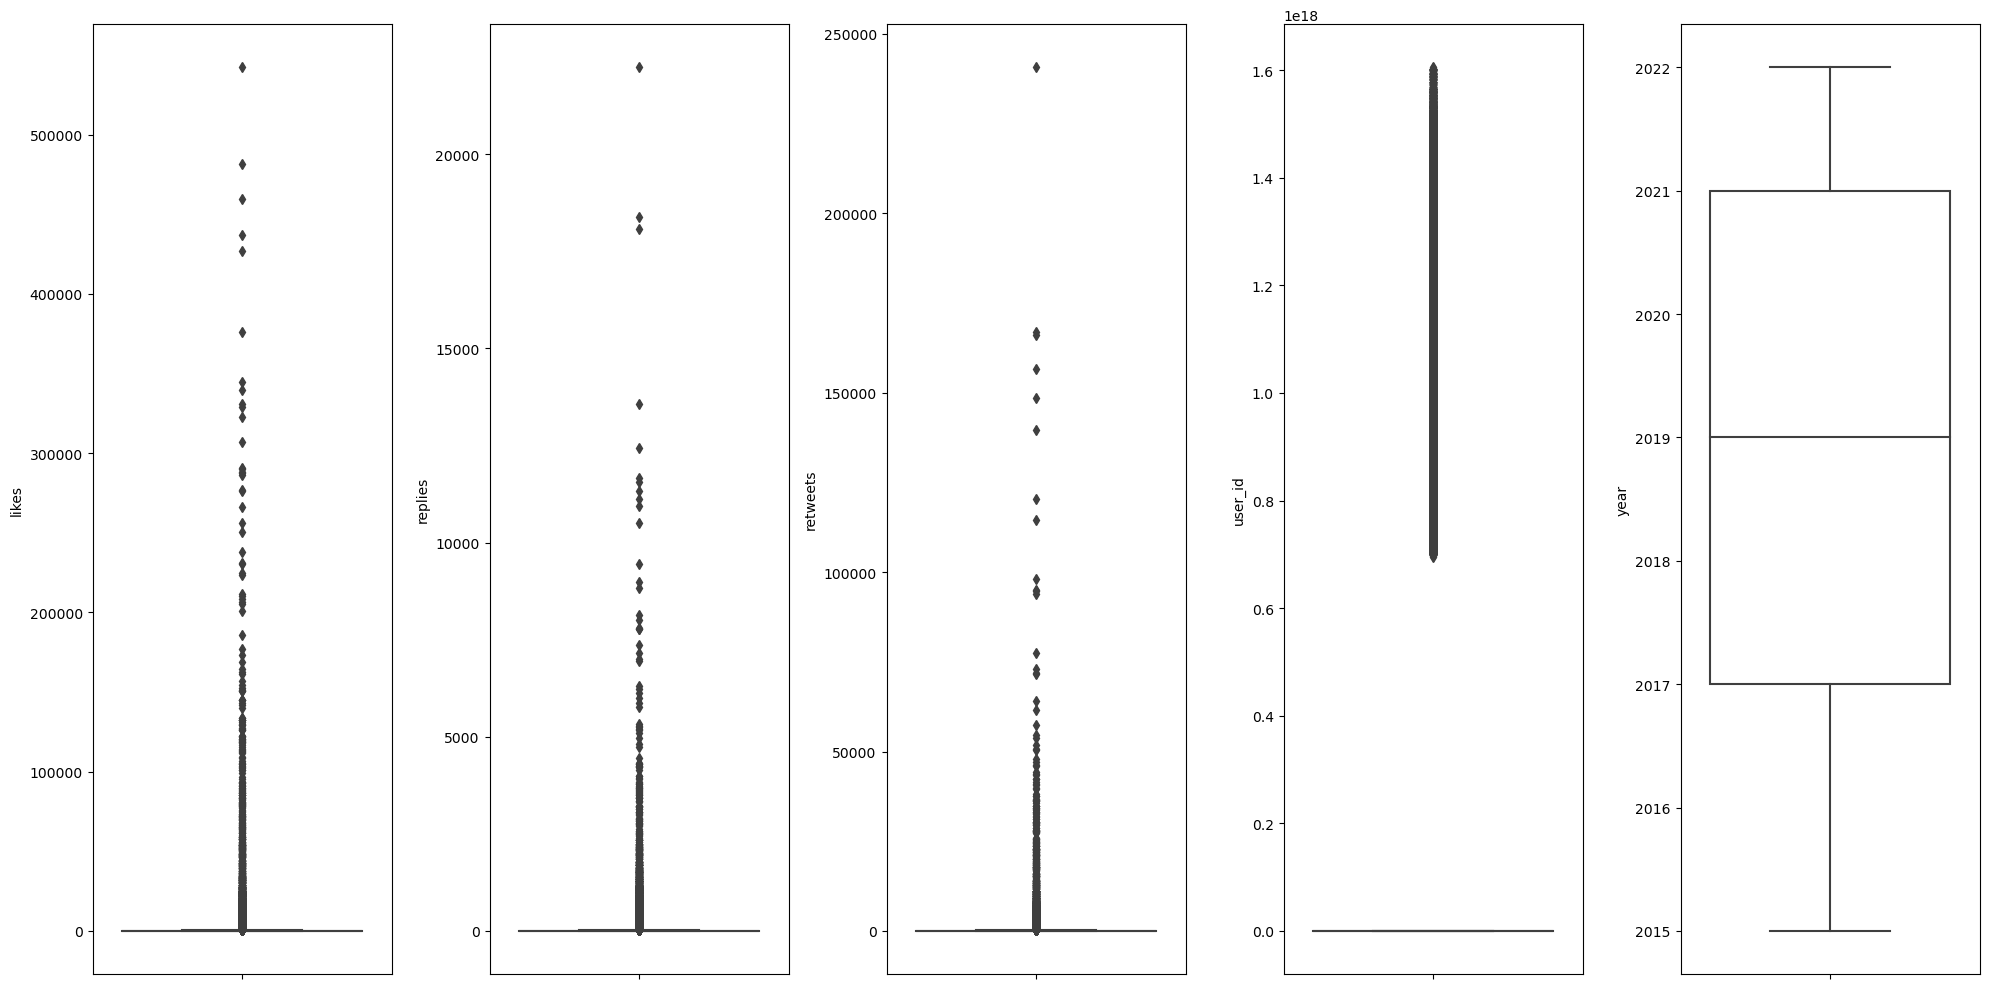


To check correlation of numeric data


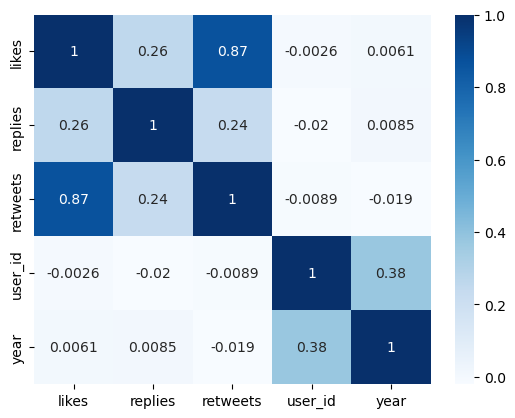

In [182]:
eda(df)

### Original tweets most common words

In [183]:
c = Counter(" ".join(df.tweet).split())
c.most_common(10)

[('the', 109706),
 ('to', 98515),
 ('of', 76998),
 ('and', 64308),
 ('a', 60594),
 ('in', 55799),
 ('for', 49921),
 ('is', 42089),
 ('on', 32951),
 ('that', 23764)]

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


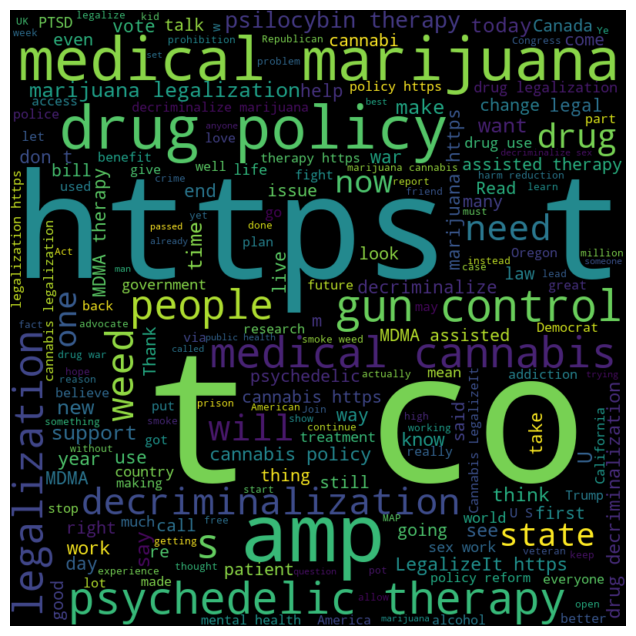

In [184]:
Displaywordcloud(" ".join(df.tweet))

### Remove all the topics words

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


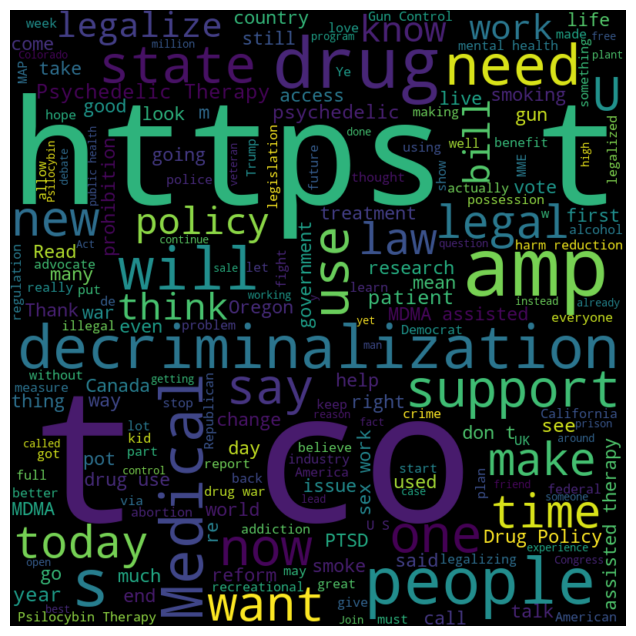

In [185]:
Displaywordcloud(" ".join(df.tweet), additional_stopwords=topics)

### Clean tweets most common words

In [186]:
c = Counter(" ".join(df.clean_tweet).split())
c.most_common(10)

[('cannabis', 45680),
 ('marijuana', 38065),
 ('s', 33272),
 ('drug', 30030),
 ('therapy', 23037),
 ('legalization', 22475),
 ('medical', 21417),
 ('policy', 21188),
 ('amp', 16665),
 ('drugs', 15917)]

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


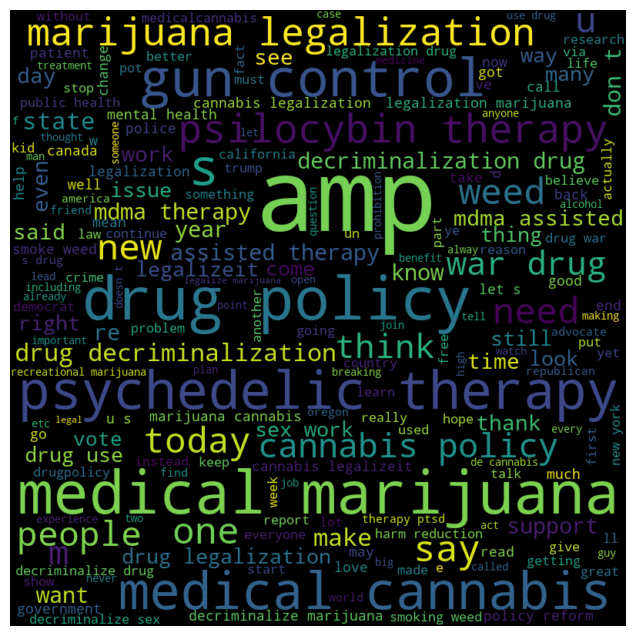

In [187]:
Displaywordcloud(" ".join(df.clean_tweet))

### Remove all the topics words

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


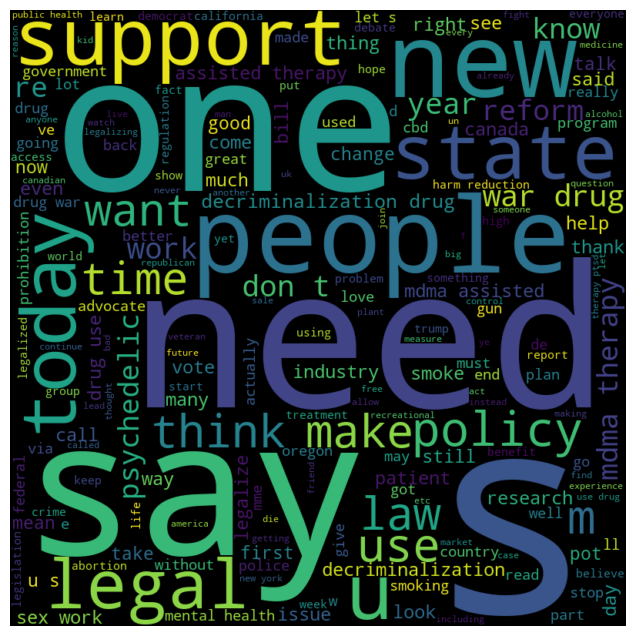

In [188]:
Displaywordcloud(" ".join(df.clean_tweet), additional_stopwords=topics + ['amp'])

### Topic Distribution

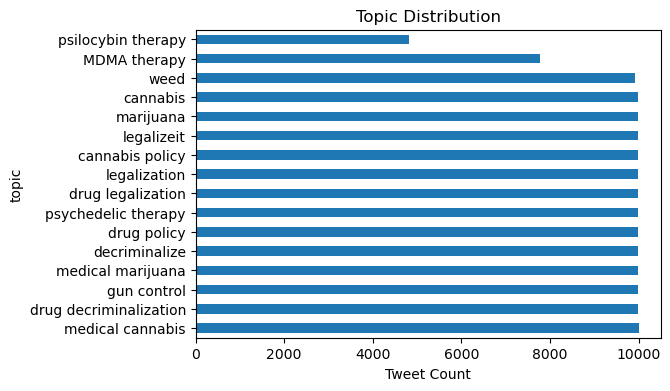

In [189]:
df.topic.value_counts().plot(kind='barh', figsize=(6,4), title='Topic Distribution')
plt.xlabel('Tweet Count')
plt.show()

## Temporal Analysis

### Year Distribution

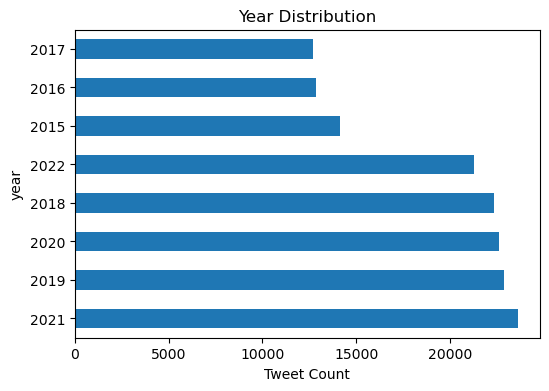

In [190]:
df.year.value_counts().plot(kind='barh', figsize=(6,4), title='Year Distribution')
plt.xlabel('Tweet Count')
plt.show()

### Number of tweets over time

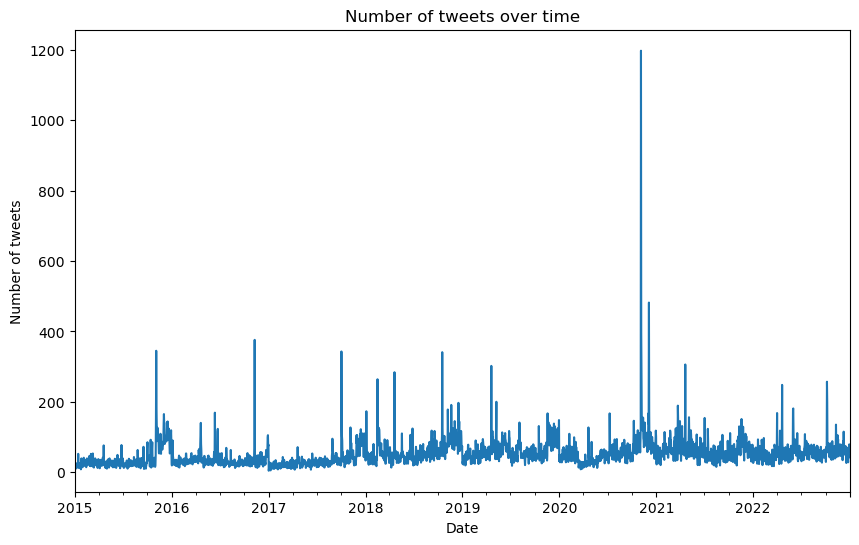

In [191]:
# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Resample the data to daily frequency and count the number of tweets each day
daily_tweets = df.resample('D', on='date').size()

# Plot the number of tweets over time
daily_tweets.plot(figsize=(10,6))
plt.title('Number of tweets over time')
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.show()

### Number of tweets by day of the week

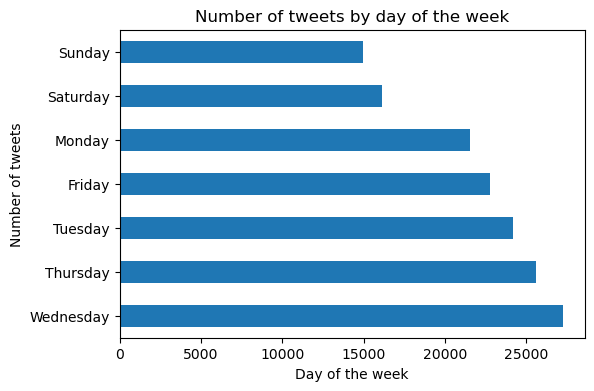

In [192]:
# Create a series for day of the week
day_of_week = df['date'].dt.day_name()

# Count the number of tweets by day of the week
tweets_by_day = day_of_week.value_counts()

# Plot the number of tweets by day of the week
tweets_by_day.plot(kind='barh', figsize=(6,4))
plt.title('Number of tweets by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of tweets')
plt.show()

### Number of tweets by hour of the day

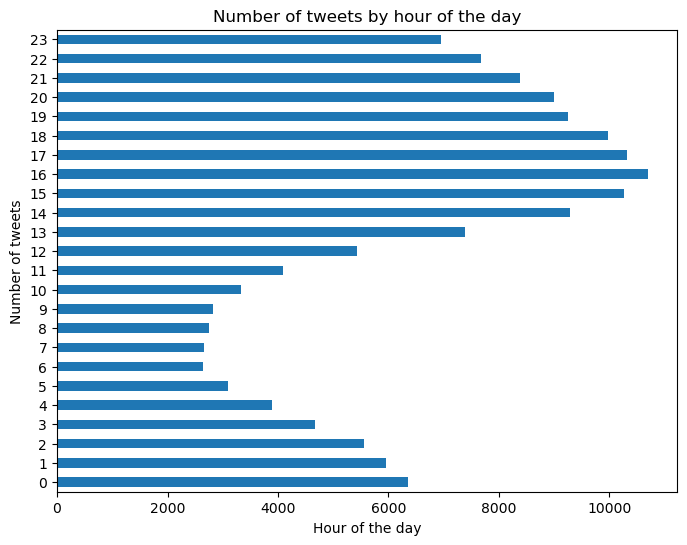

In [193]:
# Create a series for hour of the day
hour_of_day = df['date'].dt.hour

# Count the number of tweets by hour of the day
tweets_by_hour = hour_of_day.value_counts().sort_index()

# Plot the number of tweets by hour of the day
tweets_by_hour.plot(kind='barh', figsize=(8,6))
plt.title('Number of tweets by hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('Number of tweets')
plt.show()


## User Analysis

### Top 10 Users by Tweet Count

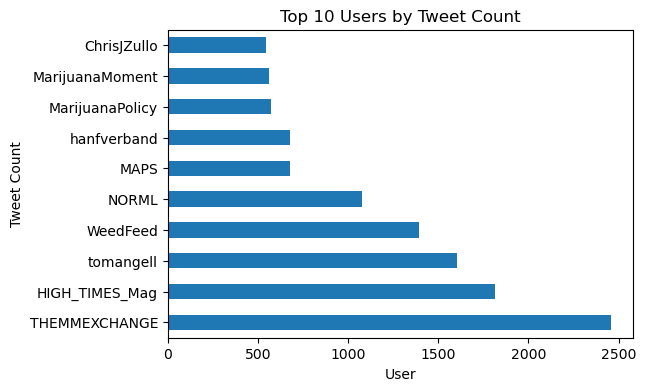

In [194]:
top_users = df['user'].value_counts().head(10)
# Plot the top 10 users and their tweet counts
top_users.plot(kind='barh', figsize=(6,4))
plt.title('Top 10 Users by Tweet Count')
plt.xlabel('User')
plt.ylabel('Tweet Count')
plt.show()

### Top 10 Users by Likes

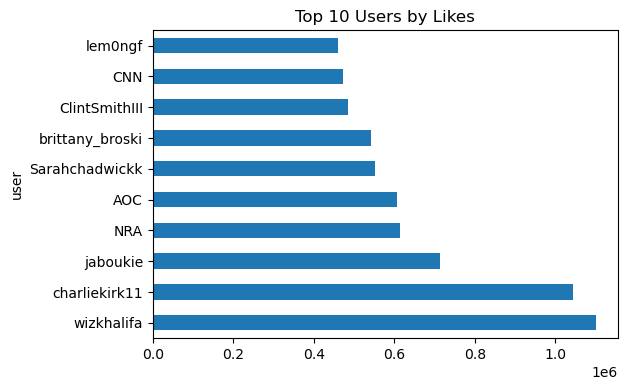

In [195]:
user_likes = df.groupby('user')['likes'].sum().sort_values(ascending=False).head(10)
# Plot the users with the most likes, replies, and retweets
user_likes.plot(kind='barh', figsize=(6,4), title='Top 10 Users by Likes')
plt.show()

### Top 10 Users by Replies

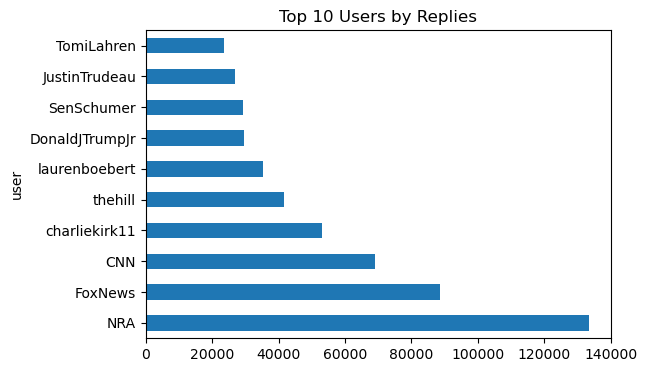

In [196]:
user_replies = df.groupby('user')['replies'].sum().sort_values(ascending=False).head(10)
user_replies.plot(kind='barh', figsize=(6,4), title='Top 10 Users by Replies')
plt.show()

### Top 10 Users by Retweets

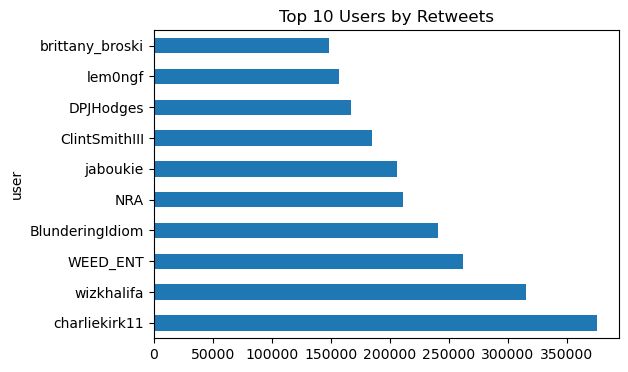

In [197]:
user_retweets = df.groupby('user')['retweets'].sum().sort_values(ascending=False).head(10)
user_retweets.plot(kind='barh', figsize=(6,4), title='Top 10 Users by Retweets')
plt.show()

### User Sentiment Analysis

In [198]:
# Count the number of positive and negative sentiments for each user
user_sentiment = df.groupby(['user', 'sentiment']).size().unstack(fill_value=0)

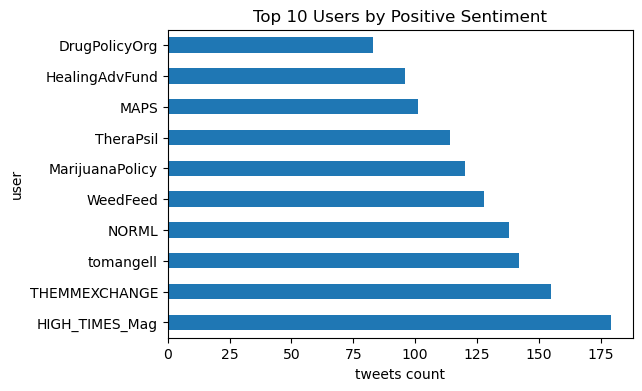

In [199]:
user_sentiment['Positive'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(6,4), title='Top 10 Users by Positive Sentiment')
plt.xlabel('tweets count')
plt.show()

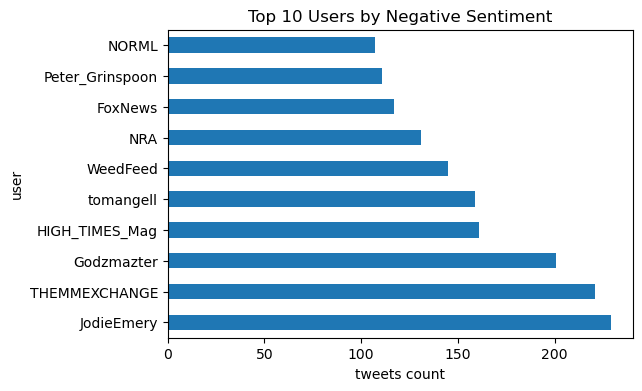

In [200]:
user_sentiment['Negative'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(6,4), title='Top 10 Users by Negative Sentiment')
plt.xlabel('tweets count')
plt.show()

### Top 10 Hashtags by Count

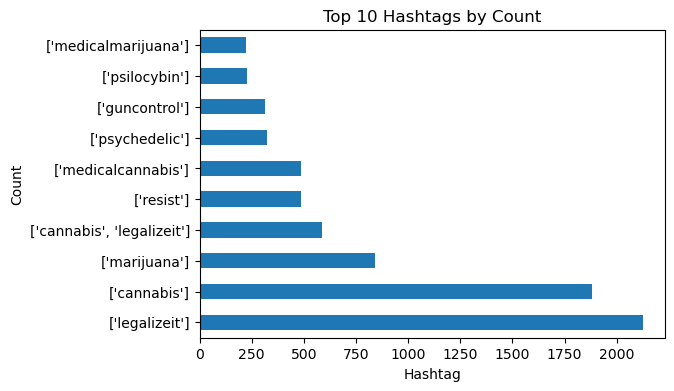

In [201]:
# Flatten the list of hashtags in each tweet into a single Series
hashtags = df['hashtags'].explode()

# Count the number of occurrences of each hashtag and take the top 10
top_hashtags = hashtags.value_counts()[1:11] # first place = [] => ignore him


# Plot the top 10 hashtags and their counts
top_hashtags.plot(kind='barh', figsize=(6,4))
plt.title('Top 10 Hashtags by Count')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()

### Sentiment Distribution

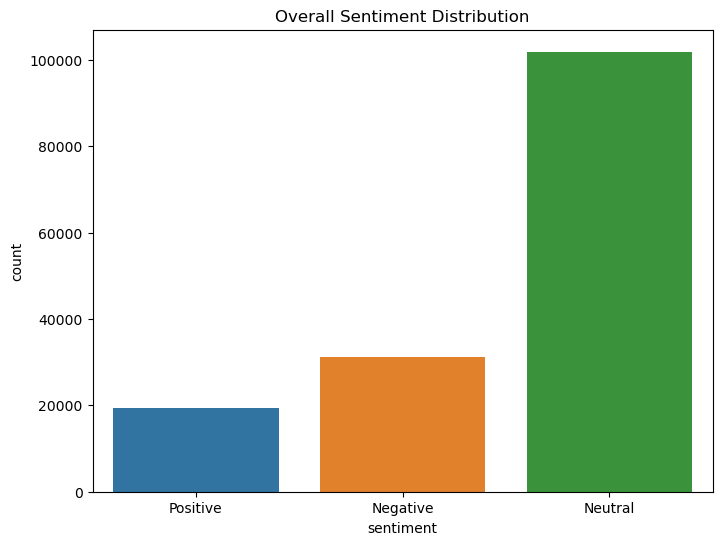

In [202]:
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=df)
plt.title('Overall Sentiment Distribution')
plt.show()

### Sentiment Distribution by Topic

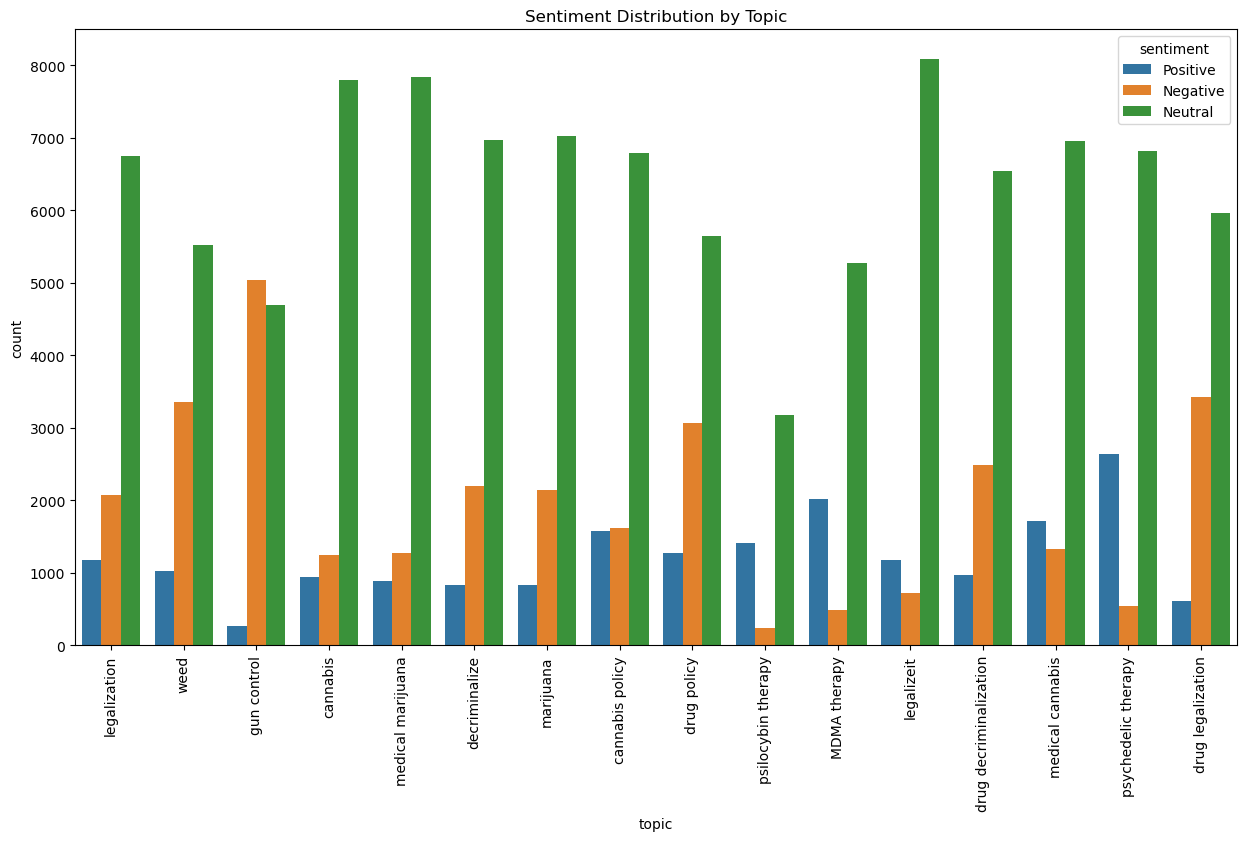

In [203]:
plt.figure(figsize=(15,8))
sns.countplot(x='topic', hue='sentiment', data=df)
plt.title('Sentiment Distribution by Topic')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

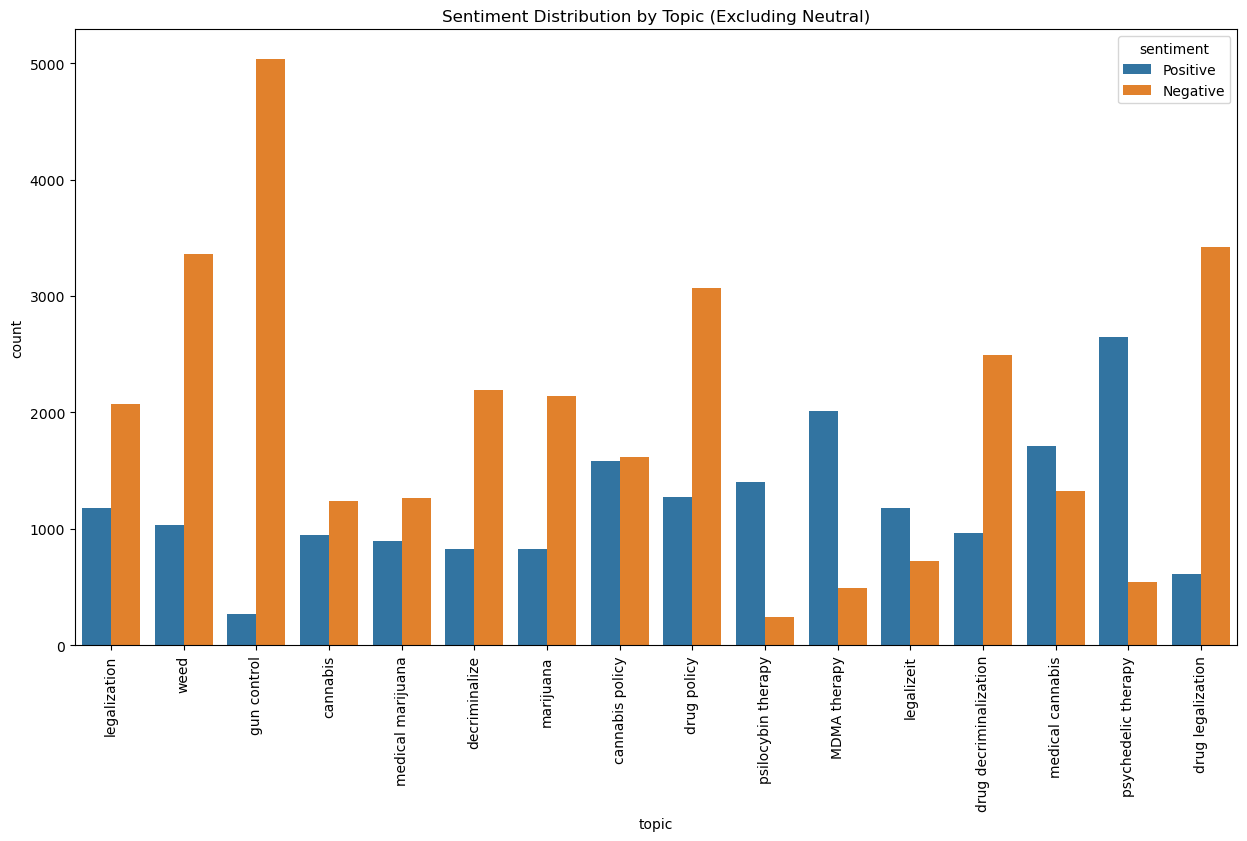

In [204]:
plt.figure(figsize=(15,8))
sns.countplot(x='topic', hue='sentiment', data=df[df['sentiment'] != 'Neutral'])
plt.title('Sentiment Distribution by Topic (Excluding Neutral)')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

### Topics with more positive sentiment than negative sentiment

In [205]:
# Group by topic and sentiment and count the number of tweets
sentiment_counts = df.groupby(['topic', 'sentiment']).size().unstack()

# Print topics where the count of positive tweets is greater than the count of negative tweets
more_positive_topics = sentiment_counts[sentiment_counts['Positive'] > sentiment_counts['Negative']].index.tolist()

print("Topics with more positive sentiment than negative sentiment:\n")
for topic in more_positive_topics:
    print(topic)


Topics with more positive sentiment than negative sentiment:

MDMA therapy
legalizeit
medical cannabis
psilocybin therapy
psychedelic therapy


### Sentiment Distribution by Year

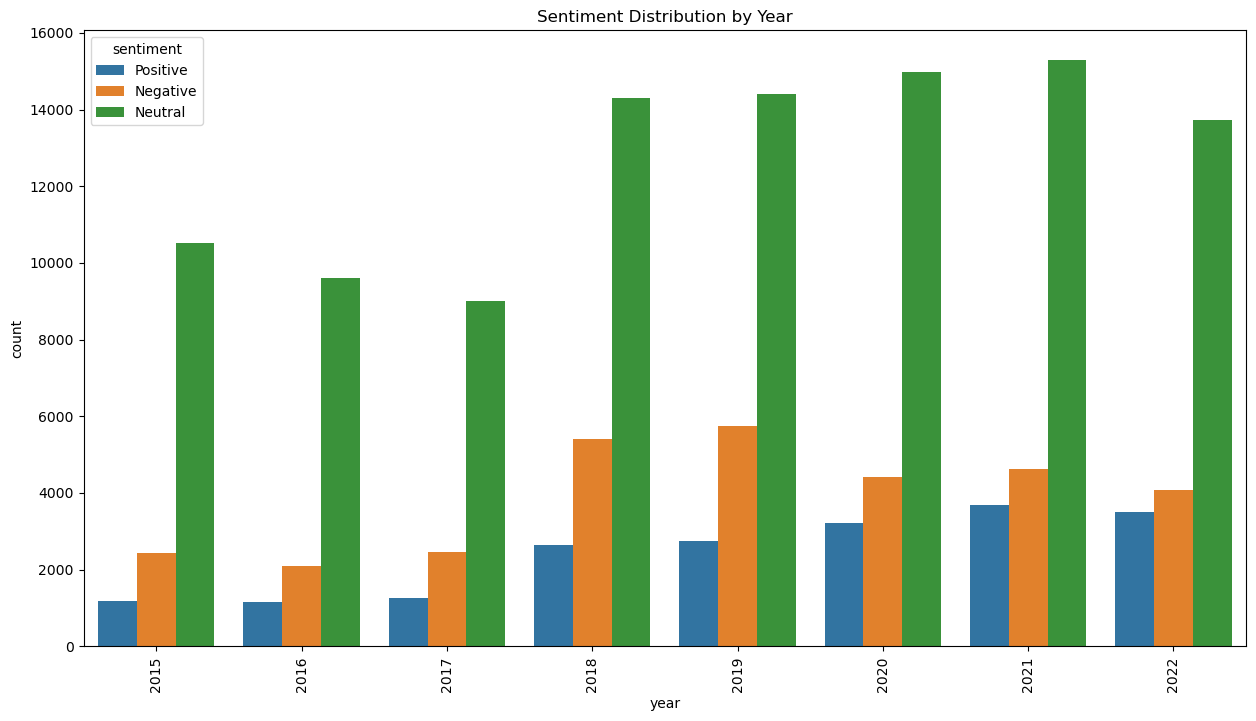

In [206]:
plt.figure(figsize=(15,8))
sns.countplot(x='year', hue='sentiment', data=df)
plt.title('Sentiment Distribution by Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

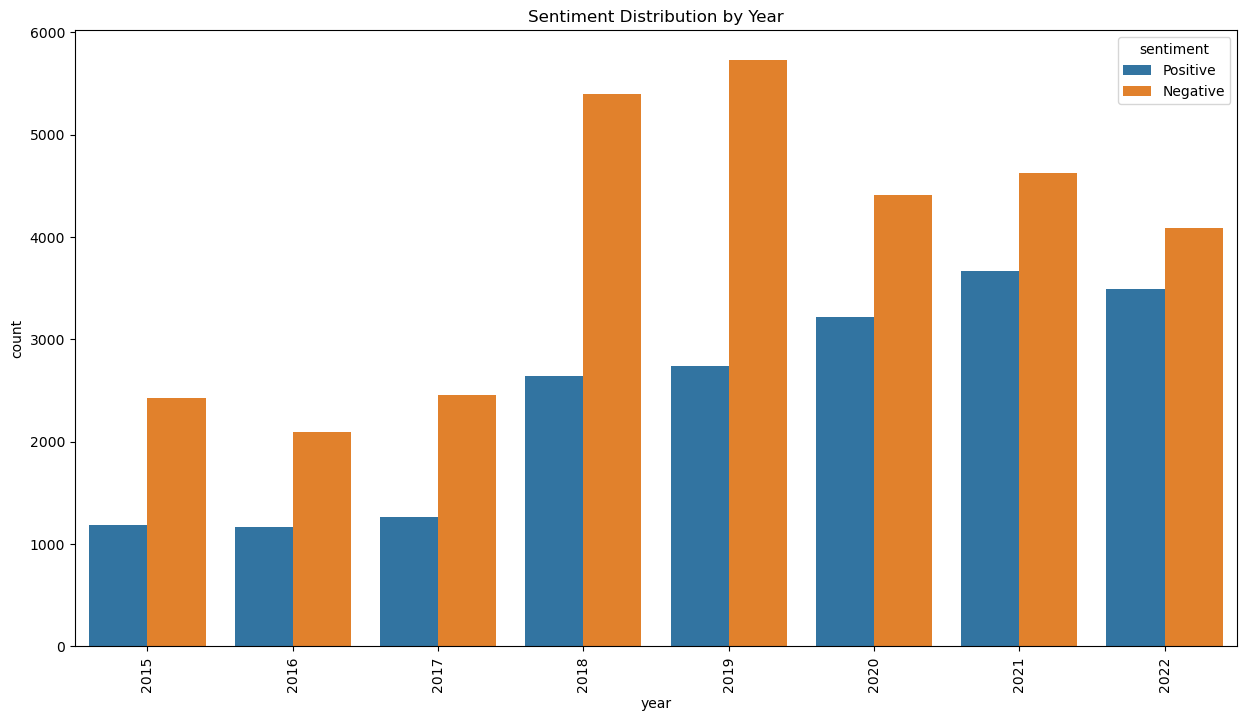

In [207]:
plt.figure(figsize=(15,8))
sns.countplot(x='year', hue='sentiment', data=df[df['sentiment'] != 'Neutral'])
plt.title('Sentiment Distribution by Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

## Topic Modeling

In [208]:
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

In [209]:
# Apply preprocessing to the 'clean_tweet' column
processed_tweets = df['clean_tweet'].map(preprocess)

In [210]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_tweets)

# Filter out words that occur less than 10 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Create Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tweet) for tweet in processed_tweets]

### 10 Topics

In [129]:
# Set training parameters
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time

In [130]:
# Make a index to word dictionary
temp = dictionary[0]  # This is only to "load" the dictionary
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [132]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.303014  0.174702       1        1  33.719455
8      0.144470 -0.340944       2        1  18.283807
7      0.120061 -0.198330       3        1  11.739518
6     -0.128247 -0.024963       4        1  11.062397
1      0.166495  0.222977       5        1   5.640348
3     -0.117246  0.022320       6        1   5.154923
9     -0.118824  0.025254       7        1   5.014002
5     -0.127540  0.037735       8        1   3.298684
2     -0.127111  0.034508       9        1   3.248728
4     -0.115073  0.046741      10        1   2.838139, topic_info=              Term          Freq         Total Category  logprob  loglift
19            drug  54797.000000  54797.000000  Default  30.0000  30.0000
9     legalization  71890.000000  71890.000000  Default  29.0000  29.0000
830        therapy  33916.000000  33916.000000  Default  28.0000  28.0000
826    psychedelic  31940.000000  31940.000000  Default  27.0000  27.0000
333          drugs  33765.000000  33765.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
3777          hold    408.254045    409.208563  Topic10  -5.0425   3.5597
5504      licensed    399.667488    400.621969  Topic10  -5.0638   3.5596
7398       sharing    388.964278    389.918794  Topic10  -5.0909   3.5596
2478          wish    388.311494    389.265988  Topic10  -5.0926   3.5596
997            hit    381.717853    382.672362  Topic10  -5.1097   3.5595

[348 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2473       6  0.999757      abuse
1422       1  0.999677     access
2287       2  0.999842  addiction
7114       8  0.998681    addicts
2937       6  0.998810    address
...      ...       ...        ...
38         1  0.999780       year
1544       4  0.999620      years
135        9  0.999592        yes
1035       6  0.999373      youth
10783      5  0.998195         zu

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 7, 2, 4, 10, 6, 3, 5])

### 5 Topics

In [133]:
# Set training parameters
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time

In [134]:
# Make a index to word dictionary
temp = dictionary[0]  # This is only to "load" the dictionary
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [135]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.115457  0.115402       1        1  45.164158
1     -0.132364 -0.174364       2        1  21.074914
3     -0.271456  0.104946       3        1  20.728788
2      0.205185 -0.304622       4        1   6.923885
0      0.314093  0.258639       5        1   6.108254, topic_info=              Term          Freq         Total Category  logprob  loglift
19            drug  51217.000000  51217.000000  Default  30.0000  30.0000
9     legalization  64266.000000  64266.000000  Default  29.0000  29.0000
333          drugs  31559.000000  31559.000000  Default  28.0000  28.0000
11       marijuana  29738.000000  29738.000000  Default  27.0000  27.0000
41        cannabis  41092.000000  41092.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
9227       onelove    581.031194    581.911594   Topic5  -5.4561   2.7940
7969            jr    606.764064    607.698235   Topic5  -5.4128   2.7940
4188          dank    633.910539    634.920446   Topic5  -5.3690   2.7939
2550    legalizeit   1354.692713   9437.297056   Topic5  -4.6096   0.8544
159           weed   1124.556171   5824.968047   Topic5  -4.7958   1.1508

[222 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1422       1  0.447962   access
1422       2  0.551810   access
188        2  0.999542    allow
4945       4  0.998564  amazing
223        3  0.999453  america
...      ...       ...      ...
300        2  0.996185     week
343        1  0.999744     well
31         3  0.999863     work
1544       1  0.999845    years
10783      4  0.999298       zu

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

### 20 Topics

In [136]:
# Set training parameters
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time

In [137]:
# Make a index to word dictionary
temp = dictionary[0]  # This is only to "load" the dictionary
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [138]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.345872 -0.055580       1        1  20.535583
14    -0.338712 -0.058963       2        1  14.564806
2     -0.025217  0.401154       3        1  13.279875
1     -0.002296  0.190165       4        1   6.875933
15     0.015129  0.077429       5        1   4.659941
12     0.022572  0.042042       6        1   4.033326
18     0.034391 -0.003041       7        1   3.277493
17     0.048880 -0.045993       8        1   3.002596
10     0.040168 -0.022317       9        1   2.965609
5      0.036137 -0.009341      10        1   2.914619
6      0.044106 -0.033287      11        1   2.753493
4      0.051379 -0.051891      12        1   2.688570
7      0.044969 -0.036200      13        1   2.636439
16     0.049422 -0.047280      14        1   2.585417
9      0.049665 -0.047874      15        1   2.493268
19     0.047537 -0.042743      16        1   2.309226
8      0.056756 -0.063952      17        1   2.155325
11     0.062092 -0.073957      18        1   2.147655
3      0.053880 -0.057977      19        1   2.070324
13     0.055013 -0.060395      20        1   2.050502, topic_info=              Term          Freq         Total Category  logprob  loglift
9     legalization  76362.000000  76362.000000  Default  30.0000  30.0000
830        therapy  44198.000000  44198.000000  Default  29.0000  29.0000
19            drug  72180.000000  72180.000000  Default  28.0000  28.0000
826    psychedelic  35141.000000  35141.000000  Default  27.0000  27.0000
41        cannabis  44702.000000  44702.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
213          ideas    425.045721    426.222714  Topic20  -4.6772   3.8843
13      production    417.976526    419.153520  Topic20  -4.6939   3.8843
751     increasing    416.496205    417.673198  Topic20  -4.6975   3.8843
4144           nyc    388.398222    389.575216  Topic20  -4.7673   3.8841
2238     solutions    386.548310    387.725304  Topic20  -4.7721   3.8840

[633 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
453      17  0.999183  abortion
2473      4  0.999395     abuse
1422      4  0.999731    access
431       5  0.998377    action
2215     17  0.997040    actual
...     ...       ...       ...
512       5  0.999243     wrong
1595      9  0.998142     wrote
38        6  0.999700      year
1544      6  0.999802     years
2163     13  0.998626      zero

[604 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 15, 3, 2, 16, 13, 19, 18, 11, 6, 7, 5, 8, 17, 10, 20, 9, 12, 4, 14])

## N-grams Analysis

In [147]:
# Tokenize the tweets
df['tokenized_tweets'] = df['clean_tweet'].apply(word_tokenize)

### Top 10 most common bigrams (N = 2)

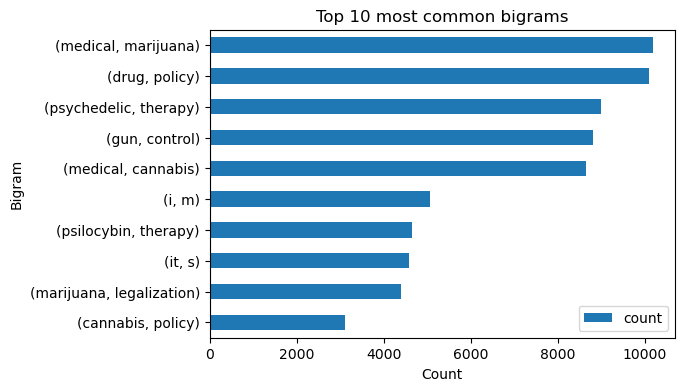

In [151]:
# Generate bigrams and count the frequency of each bigram
bigram_counts = Counter(ngram for row in df['tokenized_tweets'] for ngram in list(ngrams(row, 2)))

# Get the 10 most common bigrams
common_bigrams = bigram_counts.most_common(10)

# Convert the most common bigrams to a DataFrame
df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

# Plot the most common bigrams
df_bigrams.sort_values('count').plot(kind='barh', x='bigram', y='count', figsize=(6, 4))
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 10 most common bigrams')
plt.show()

### Top 10 most common trigrams (N = 3)

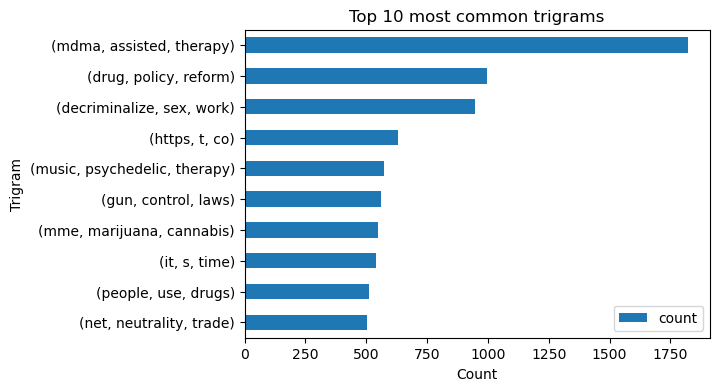

In [152]:
# Generate bigrams and count the frequency of each bigram
trigram_counts = Counter(ngram for row in df['tokenized_tweets'] for ngram in list(ngrams(row, 3)))

# Get the 10 most common bigrams
common_trigrams = trigram_counts.most_common(10)

# Convert the most common bigrams to a DataFrame
df_trigrams = pd.DataFrame(common_trigrams, columns=['trigram', 'count'])

# Plot the most common bigrams
df_trigrams.sort_values('count').plot(kind='barh', x='trigram', y='count', figsize=(6, 4))
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Top 10 most common trigrams')
plt.show()

# Named-Entity Recognition

In [224]:
df['named_entity']=df['clean_tweet'].apply(lambda t:get_entities(t))

In [225]:
count_entities_dict ={}
for d in df['named_entity']:
    for entity_type,entity_set in d.items():
        if entity_type not in count_entities_dict:
            count_entities_dict[entity_type] = {}
        for name in entity_set:
            name = name.replace('\n',' ').strip().lower()
            if name not in count_entities_dict[entity_type]:
                count_entities_dict[entity_type][name] = 0
            count_entities_dict[entity_type][name] += 1
count_entities_dict

{'NORP': {'american': 644,
  'democrats': 1157,
  'republican': 496,
  'americans': 1128,
  'indian': 73,
  'dems': 366,
  'democrat': 370,
  'argentinian': 8,
  'pennsylvanians': 37,
  'uconn': 2,
  'republicans': 862,
  'south dakotans': 9,
  'dem': 243,
  'democratic': 273,
  'jerseyans': 2,
  'nebraskans': 51,
  'nn20': 1,
  'filipino': 3,
  'chinese': 62,
  'somali': 2,
  'palestinians': 7,
  'african americans': 31,
  'mexican': 247,
  'ny dems': 2,
  'christian': 70,
  'jenashleywright': 2,
  'livepdfans': 5,
  'ilpjusapol': 1,
  'canadian': 788,
  'argentinians': 1,
  'puerto rican': 6,
  'russian': 137,
  'catholic': 25,
  'kamalaharris': 21,
  'irish': 118,
  'kwawkese': 2,
  'muslim': 73,
  'canadians': 462,
  'paulgazelka': 1,
  'delawareans': 1,
  'jonrog1': 1,
  'akhalifa18': 1,
  'himalayan': 2,
  'nazi': 28,
  'aaronhernandez': 1,
  'italy': 1,
  'nigerians': 4,
  'socialists': 19,
  'eballgogogo': 1,
  'riggleman': 1,
  'joncoopertweets': 7,
  'brazilian': 12,
  'jdmah

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


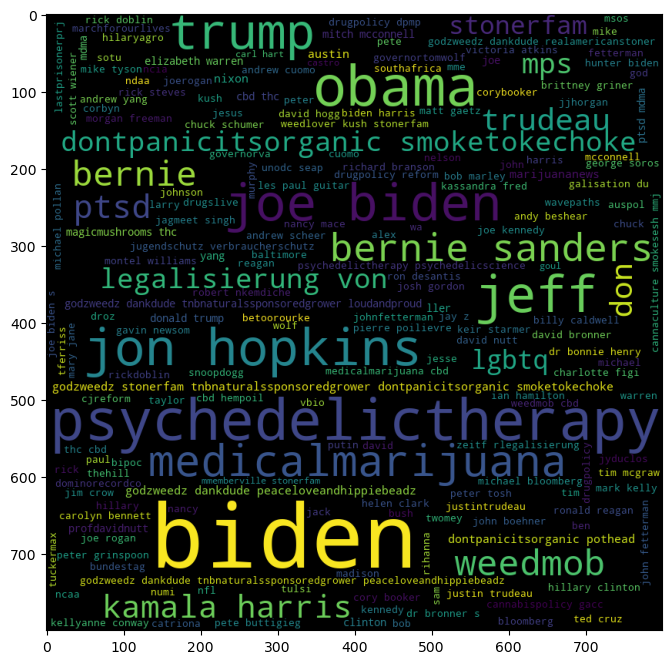

In [230]:
draw_entities_word_cloud("PERSON",1)

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


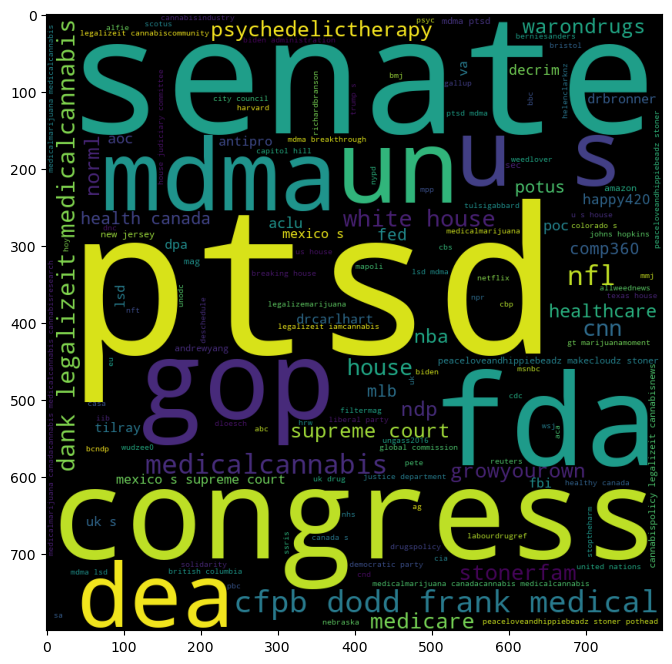

In [231]:
draw_entities_word_cloud("ORG",1)

C:\Users\admin\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


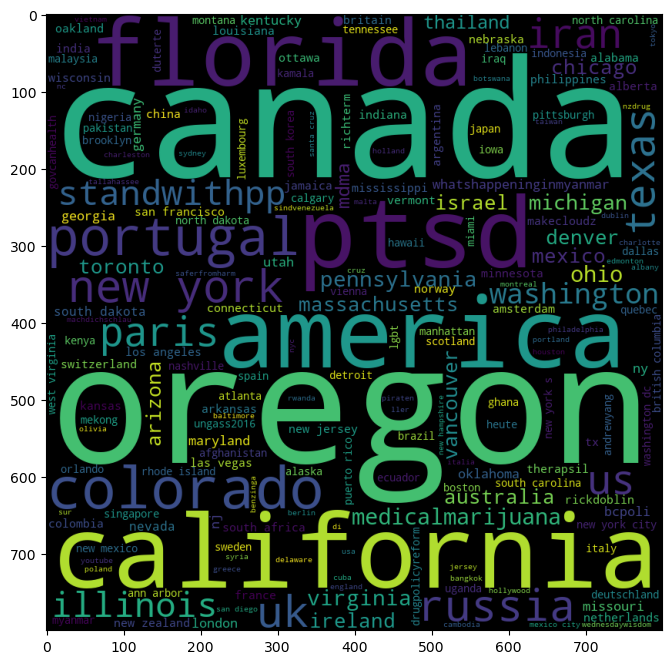

In [232]:
draw_entities_word_cloud("GPE",1)

In [236]:
df.drop(['clean_tweet', 'named_entity'], axis=1)

date             user  \
0      2020-06-07 21:50:52+00:00  brittany_broski   
1      2020-11-04 23:49:38+00:00              AOC   
2      2020-07-28 13:21:06+00:00   MargBarAmerica   
3      2020-12-04 18:27:14+00:00          nytimes   
4      2020-07-28 12:57:33+00:00   YesYoureRacist   
...                          ...              ...   
152451 2015-12-29 13:21:28+00:00         lanceb62   
152452 2015-10-17 15:05:00+00:00        JamieGump   
152453 2015-10-23 12:37:56+00:00     KerryWMartin   
152454 2015-08-01 01:10:26+00:00  PunkRockLiberty   
152455 2015-01-03 06:28:09+00:00     matkabolava_   

                                                    tweet   likes  replies  \
0       Next up on the docket: free every black man un...  542202      938   
1       Shout out to the hard work of grassroots organ...  289942     1573   
2       i still can't get over the democrats overwhelm...   24154      156   
3       The House has voted to decriminalize marijuana...   18705      715   
4       Good morning! 57% of Americans and 78% of Demo...   15003      117   
...                                                   ...     ...      ...   
152451  Soros Foundation promoted drug legalization wo...       1        0   
152452  Waiting to hear @TexasGOP say anything about #...       1        0   
152453  "Police work for #narcos because they pay bett...       0        1   
152454  Govt-Funded Anti-Drug Program “D.A.R.E.” Just ...       0        0   
152455  that is why I'm so against the legalization of...       0        1   

        retweets                                       hashtags  \
0         148464                                             []   
1          18519                                             []   
2           1975                                             []   
3           5606                                             []   
4           4613                                             []   
...          ...                                            ...   
152451         1                                             []   
152452         0  ['druglegalization', 'ttf', 'bordersecurity']   
152453         0                 ['narcos', 'druglegalization']   
152454         1                                             []   
152455         0                                             []   

                    user_id              topic  year sentiment  
0       1262905431602589696       legalization  2020  Positive  
1                 138203134       legalization  2020  Positive  
2                  17109158       legalization  2020  Negative  
3                    807095       legalization  2020   Neutral  
4                 858924511       legalization  2020   Neutral  
...                     ...                ...   ...       ...  
152451           2874372175  drug legalization  2015   Neutral  
152452            528261651  drug legalization  2015   Neutral  
152453           2545495004  drug legalization  2015   Neutral  
152454           1278031291  drug legalization  2015   Neutral  
152455           2376222163  drug legalization  2015  Negative  

[152456 rows x 11 columns]